In [1]:
import video_data_classes as vid
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd.profiler as profiler
import torch
import h5py
import utils
from time import perf_counter
from skimage import io
from importlib import reload
from IPython.core.debugger import set_trace
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [55]:
class SuperResNetwork(nn.Module):
    def __init__(self):
        super(SuperResNetwork, self).__init__()

        self.input_layer = nn.Conv2d(51, 16, (3, 3), padding=1)
        self.output_layer = nn.ConvTranspose2d(16, 3, (4, 4), stride=4)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        first_input = x[0, :, :, :, :]
        sequence_length = x.shape[0]
        self.batch_size = x.shape[1]
        initial_zeros = torch.zeros((self.batch_size, 48, 64, 64), device='cuda:0')
        
        y = self.input_layer(torch.cat([first_input, initial_zeros], dim=1)) # concatenate the first input with zeros in the channel dimension
        y = self.activation(y)
        y = self.output_layer(y)
        y = torch.sigmoid(y)
        output = torch.unsqueeze(y, 0)
        
        for i in range(1, sequence_length):
            y = self.input_layer(torch.cat([x[i, :, :, :, :], self.space_to_depth(output[i - 1, :, :, :, :])], dim=1))
            y = self.activation(y)
            y = self.output_layer(y)
            y = torch.sigmoid(y)
            output = torch.cat([output, torch.unsqueeze(y, 0)], dim=0)
            
        return output
            
    def space_to_depth(self, HR_frames):
        LR_depth_frames = torch.empty((self.batch_size, 48, 64, 64), device='cuda:0')
        
        LR_depth_frames[:, 0:3, :, :] = HR_frames[:, :, ::4, ::4]
        LR_depth_frames[:, 3:6, :, :] = HR_frames[:, :, 1::4, ::4]
        LR_depth_frames[:, 6:9, :, :] = HR_frames[:, :, 2::4, ::4]
        LR_depth_frames[:, 9:12, :, :] = HR_frames[:, :, 3::4, ::4]
        LR_depth_frames[:, 12:15, :, :] = HR_frames[:, :, ::4, 1::4]
        LR_depth_frames[:, 15:18, :, :] = HR_frames[:, :, 1::4, 1::4]
        LR_depth_frames[:, 18:21, :, :] = HR_frames[:, :, 2::4, 1::4]
        LR_depth_frames[:, 21:24, :, :] = HR_frames[:, :, 3::4, 1::4]
        LR_depth_frames[:, 24:27, :, :] = HR_frames[:, :, ::4, 2::4]
        LR_depth_frames[:, 27:30, :, :] = HR_frames[:, :, 1::4, 2::4]
        LR_depth_frames[:, 30:33, :, :] = HR_frames[:, :, 2::4, 2::4]
        LR_depth_frames[:, 33:36, :, :] = HR_frames[:, :, 3::4, 2::4]
        LR_depth_frames[:, 36:39, :, :] = HR_frames[:, :, ::4, 3::4]
        LR_depth_frames[:, 39:42, :, :] = HR_frames[:, :, 1::4, 3::4]
        LR_depth_frames[:, 42:45, :, :] = HR_frames[:, :, 2::4, 3::4]
        LR_depth_frames[:, 45:48, :, :] = HR_frames[:, :, 3::4, 3::4]
        
        return LR_depth_frames
            


In [56]:
# Define the network, loss function, and optimizer

network = SuperResNetwork()
network.to('cuda:0')
criterion = nn.MSELoss()
optimizer = optim.Rprop(network.parameters())

In [5]:
# 'dataset' represents a dataset of short video samples

video_directory = r'C:\Users\John\PythonVenvs\VideoSuperResolution\Scripts\Raw Data\Raw, Half-Size, and PNGs'
dataset = vid.VideoDataset(video_directory, 10)

In [3]:
# Creates an hdf5 file of video data for fast i/o during training

utils.generate_hdf5(dataset)

23090


In [57]:
with h5py.File(r'E:\hdf5_file.hdf5', 'r') as data:
    writer = SummaryWriter()

    train_batch_size = 4
    val_batch_size = 2
    total_batch_size = train_batch_size + val_batch_size
    batch_indices = utils.make_batches(len(dataset), total_batch_size)

    x = torch.empty(dataset.sequence_length, total_batch_size, 3, 64, 64, device='cuda:0')
    y = torch.empty(dataset.sequence_length, total_batch_size, 3, 256, 256, device='cuda:0')

    for i in list(range(batch_indices.shape[0])):
        x[...] = torch.tensor(data['X'][batch_indices[i, :], ...].transpose(1, 0, 2, 3, 4), device='cuda:0') / 255.0 # shape [dataset.sequence_length, total_batch_size, c, h, w]
        y[...] = torch.tensor(data['Y'][batch_indices[i, :], ...].transpose(1, 0, 2, 3, 4), device='cuda:0') / 255.0 # shape [dataset.sequence_length, total_batch_size, c, h, w]

        optimizer.zero_grad()
        output = network(x[:, :train_batch_size, ...])
        loss = criterion(output, y[:, :train_batch_size, ...])
        loss.backward()
        optimizer.step()

        val_output = network(x[:, train_batch_size:, ...])
        val_loss = criterion(val_output, y[:, train_batch_size:, ...])

        writer.add_scalar('Loss/Train', loss, i)
        writer.add_scalar('Loss/Validation', val_loss, i)

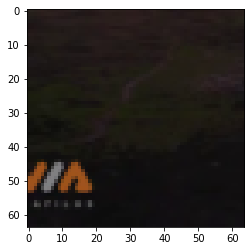

In [62]:
plt.imshow(x[0, 0, :, :, :].cpu().detach().permute(1, 2, 0))

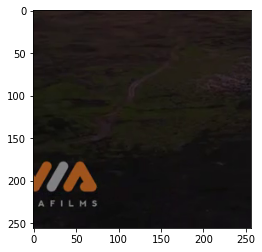

In [63]:
plt.imshow(y[0, 0, :, :, :].cpu().detach().permute(1, 2, 0))

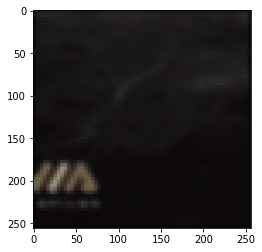

In [66]:
plt.imshow(output[5, 0, :, :, :].cpu().detach().permute(1, 2, 0))

In [12]:
reload(utils)

<module 'utils' from 'C:\\Users\\John\\PythonVenvs\\VideoSuperResolution\\Scripts\\VideoSuperResolution\\utils.py'>